# Advantage actor-critic (A2C)

## 1. 相关概念

策略梯度定理:

$$\frac{\partial J(\theta)}{\partial \theta} = \mathbb{E}_S\left[ \mathbb{E}_{A \sim \pi(\cdot \mid S; \theta)} \left[ \frac{\partial \ln(A \mid S; \theta)}{\partial \theta} \cdot Q_\pi(S, A) \right]\right]$$

定理: 如果函数$b$不依赖于$A$，则对任意的$s$，有:

$$
\mathbb{E}_{A \sim \pi(\cdot \mid s; \theta)}\left[ b \cdot \frac{\partial \ln \pi(A \mid s; \theta)}{\partial \theta} \right] = 0
$$

证明:

$$
\begin{aligned}
    & \mathbb{E}_{A \sim \pi(\cdot \mid s; \theta)}\left[ b \cdot \frac{\partial \ln \pi(A \mid s; \theta)}{\partial \theta} \right] \\
    & = b \cdot \mathbb{E}_{A \sim \pi(\cdot \mid s; \theta)}\left[ \frac{\partial \ln \pi(A \mid s; \theta)}{\partial \theta} \right] \\
    & = b \cdot \sum_{a \in \mathcal{A}} \pi(a \mid s; \theta) \cdot \frac{\partial \ln \pi(a \mid s; \theta)}{\partial \theta} \\ 
    & = b \cdot \sum_{a \in \mathcal{A}} \frac{\partial \pi(a \mid s; \theta)}{\partial \theta} \\
    & = b \cdot \frac{\partial}{\partial \theta} \sum_{a \in \mathcal{A}} \pi(a \mid s; \theta) \\
    & = b \cdot \frac{\partial}{\partial \theta} \sum_{a \in \mathcal{A}} 1 \\
    & = 0
\end{aligned}
$$

从而近似梯度可以写为:

$$g_b(s, a; \theta) = [Q_\pi(s, a) - b] \cdot \Delta_\theta \ln \pi(a \mid s; \theta)$$

仍是对策略梯度的无偏估计，但会影响方差: $Var = \mathbb{E}_{S, A} \left[\| g_b(S, A; \theta) - \Delta_{\theta} J(\theta) \|^2\right]$。$b$接近$Q_\pi(s, a)$关于$a$的均值时，方差会比较小，从而$b = V_\pi(s)$是很好的基线。

## 2. 训练方法

设策略网络 (Actor)、价值网络 (Critic) 和目标网络 (Target Critic) 的当前参数分别为 $\theta_{now}$, $w_{now}$ 和 $w_{now}^-$。

(1) 在当前状态 $s_t$，Actor 网络根据策略进行动作选择并执行，得到 $a_t \sim \pi(\cdot \mid s_t; \theta_{now})$，同时观测到奖励 $r_t$ 和新状态 $s_{t+1}$；

(2) Actor 网络在新状态 $s_{t+1}$ 上选择下一个动作 $\tilde{a}_{t+1} = \pi(\cdot \mid s_{t+1}; \theta_{now})$，但不执行该动作；

(3) Critic 网络对当前动作进行评分，得到 $\hat{q}_t = q(s_t, a_t; w_{now})$；

(4) 目标网络对下一个状态和动作评分，得到 $\hat{q}_{t+1} = q(s_{t+1}, \tilde{a}_{t+1}; w_{now}^-)$；

(5) 计算 TD 目标和 TD 误差：
   $$ \hat{y}_t = r_t + \gamma \cdot \hat{q}_{t+1} $$
   $$ \delta_t = \hat{y}_t - \hat{q}_t $$

(6) 使用 TD 误差更新 Critic 网络：
   $$ w_{new} = w_{now} - \alpha \cdot \delta_t \cdot \nabla_w q(s_t, a_t; w_{now}) $$

(7) 使用优势函数更新 Actor 网络：
   $$ \theta_{new} = \theta_{now} + \beta \cdot \delta_t \cdot \nabla_{\theta} \ln \pi(a_t \mid s_t; \theta_{now}) $$

(8) 目标网络软更新（可在特定间隔执行）：
   $$ w_{new}^- = \tau \cdot w_{new} + (1 - \tau) \cdot w_{now}^- $$

### 2.1. 备注

- **TD 目标 (TD Target)**：是用于更新 Critic 网络的目标，表示期望的未来奖励。
- **TD 误差 (TD Error)**：表示当前 Critic 估计的值和 TD 目标的差异，用于更新 Critic 网络。
- **Advantage (优势函数)**：是 Actor 网络优化的依据，衡量当前动作相比于策略的期望值的好坏。
- **目标网络 (Target Network)**：目标网络用于提高稳定性，防止 Critic 网络频繁更新导致训练不稳定。

# 代码实现

In [1]:
# 导入库
import os
import gym
import argparse
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义价值网络
class ValueNet(nn.Module):
    def __init__(self, state_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# 定义策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_actions)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob = F.softmax(x, dim=-1)
        return prob

In [4]:
# 定义A2C类
class A2C:
    def __init__(self, state_size, num_actions, discount, device):
        self.discount = discount
        self.device = device
        self.actor = PolicyNet(state_size, num_actions).to(device)
        self.critic = ValueNet(state_size).to(device)
        self.target = ValueNet(state_size).to(device)
        self.target.load_state_dict(self.critic.state_dict())
        
    def get_action(self, state):
        # state: (state_size,)
        # prob: (state_size,)
        prob = self.actor(state)
        m = Categorical(prob)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob
    
    def compute_loss(self, bs, blogp, br, bd, bns):
        # bs, bns: (batch_size, state_size)
        # blogp, br, bd: (batch_size,)
        # current_value: (batch_size,)
        current_value = self.critic(bs).squeeze()
        # next_value: (batch_size,)
        next_value = self.target(bns).squeeze()
        # target_value: (batch_size,)
        target_value = br + self.discount * (1 - bd) * next_value
        # advantage: (batch_size,)
        advantage = target_value - self.critic(bs).squeeze()
        policy_loss = -(blogp * advantage.detach()).mean() 
        value_loss = F.mse_loss(current_value, target_value.detach())
        return policy_loss, value_loss
        
        
    def soft_update(self, tau=0.01):
        for target_param, param in zip(self.target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1 - tau) + param * tau)

In [5]:
# 训练
def train(args, env):
    agent = A2C(args.state_size, args.num_actions, args.discount, args.device)
    value_optimizer = torch.optim.Adam(agent.critic.parameters(), lr=args.value_lr)
    policy_optimizer = torch.optim.Adam(agent.actor.parameters(), lr=args.policy_lr)
    
    episode_reward = 0
    episode_length = 0
    episode_num = 0
    max_episode_reward = float('-inf')
    
    agent.actor.train()
    agent.critic.train()
    state, _ = env.reset()
    writer = SummaryWriter()
    save_path = os.path.join(args.output_dir, 'model.bin')
    
    for i in range(args.max_steps):
        action, log_prob = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        
        reward_tensor = torch.tensor([reward], dtype=torch.float32).to(args.device)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(args.device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(args.device)
        done_tensor = torch.tensor([done], dtype=torch.float32).to(args.device)
        
        policy_loss, value_loss = agent.compute_loss(state_tensor, log_prob, reward_tensor, done_tensor, next_state_tensor)
        
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()
        
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()
        
        state = next_state
        
        if done:
            if episode_reward >= max_episode_reward:
                max_episode_reward = episode_reward
                torch.save(agent.actor.state_dict(), save_path)
                
            writer.add_scalar('Maximum reward', max_episode_reward, episode_num)
            writer.add_scalar('Episode reward', episode_reward, episode_num)
            writer.add_scalar('Episode length', episode_length, episode_num)
            print(f'step = {i}, reward = {episode_reward:.0f}, length = {episode_length}, max reward = {max_episode_reward}')
            
            episode_reward = 0
            episode_length = 0
            episode_num += 1
            agent.soft_update()
            state, _ = env.reset()
            
    writer.close()

In [6]:
# 测试
def eval(args, env):
    agent = A2C(args.state_size, args.num_actions, args.discount, args.device)
    model_path = os.path.join(args.output_dir, 'model.bin')
    agent.actor.load_state_dict(torch.load(model_path))
    agent.actor.to(args.device)
    agent.actor.eval()
    
    episode_reward = 0
    episode_length = 0
    state, _ = env.reset()
    for _ in range(5000):
        action, _ = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            state, _ = env.reset()
            print(f'episode reward = {episode_reward:.0f}, episode length = {episode_length}')
            episode_reward = 0
            episode_length = 0

In [7]:
# 运行
args = argparse.Namespace()
args.env = 'CartPole-v1'
args.state_size = 4
args.num_actions = 2
args.discount = 0.99
args.max_steps = int(2e5)
args.policy_lr = 1e-4
args.value_lr = 1e-3
args.output_dir = 'output'
if torch.cuda.is_available():
    args.device = torch.device('cuda')
else:
    args.device = torch.device('cpu')
    
os.makedirs(args.output_dir, exist_ok=True)
    
env = gym.make(args.env)
env.reset(seed=42)
env.action_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if args.device == torch.device('cuda'):
    torch.cuda.manual_seed(42)
print('Training started...')
train(args, env)
print('Training completed!')

print('Evaluation started...')
eval(args, env)
print('Evaluation completed!')

Training started...
step = 21, reward = 22, length = 22, max reward = 22.0
step = 49, reward = 28, length = 28, max reward = 28.0
step = 70, reward = 21, length = 21, max reward = 28.0
step = 85, reward = 15, length = 15, max reward = 28.0
step = 107, reward = 22, length = 22, max reward = 28.0
step = 134, reward = 27, length = 27, max reward = 28.0
step = 153, reward = 19, length = 19, max reward = 28.0


/Users/xavier/PythonCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


step = 166, reward = 13, length = 13, max reward = 28.0
step = 196, reward = 30, length = 30, max reward = 30.0
step = 225, reward = 29, length = 29, max reward = 30.0
step = 253, reward = 28, length = 28, max reward = 30.0
step = 281, reward = 28, length = 28, max reward = 30.0
step = 314, reward = 33, length = 33, max reward = 33.0
step = 331, reward = 17, length = 17, max reward = 33.0
step = 345, reward = 14, length = 14, max reward = 33.0
step = 368, reward = 23, length = 23, max reward = 33.0
step = 389, reward = 21, length = 21, max reward = 33.0
step = 412, reward = 23, length = 23, max reward = 33.0
step = 446, reward = 34, length = 34, max reward = 34.0
step = 478, reward = 32, length = 32, max reward = 34.0
step = 495, reward = 17, length = 17, max reward = 34.0
step = 507, reward = 12, length = 12, max reward = 34.0
step = 532, reward = 25, length = 25, max reward = 34.0
step = 559, reward = 27, length = 27, max reward = 34.0
step = 576, reward = 17, length = 17, max reward

step = 3184, reward = 16, length = 16, max reward = 107.0
step = 3203, reward = 19, length = 19, max reward = 107.0
step = 3220, reward = 17, length = 17, max reward = 107.0
step = 3252, reward = 32, length = 32, max reward = 107.0
step = 3272, reward = 20, length = 20, max reward = 107.0
step = 3292, reward = 20, length = 20, max reward = 107.0
step = 3309, reward = 17, length = 17, max reward = 107.0
step = 3322, reward = 13, length = 13, max reward = 107.0
step = 3343, reward = 21, length = 21, max reward = 107.0
step = 3357, reward = 14, length = 14, max reward = 107.0
step = 3377, reward = 20, length = 20, max reward = 107.0
step = 3391, reward = 14, length = 14, max reward = 107.0
step = 3404, reward = 13, length = 13, max reward = 107.0
step = 3415, reward = 11, length = 11, max reward = 107.0
step = 3428, reward = 13, length = 13, max reward = 107.0
step = 3439, reward = 11, length = 11, max reward = 107.0
step = 3466, reward = 27, length = 27, max reward = 107.0
step = 3476, r

step = 6245, reward = 25, length = 25, max reward = 107.0
step = 6264, reward = 19, length = 19, max reward = 107.0
step = 6284, reward = 20, length = 20, max reward = 107.0
step = 6297, reward = 13, length = 13, max reward = 107.0
step = 6307, reward = 10, length = 10, max reward = 107.0
step = 6330, reward = 23, length = 23, max reward = 107.0
step = 6370, reward = 40, length = 40, max reward = 107.0
step = 6380, reward = 10, length = 10, max reward = 107.0
step = 6410, reward = 30, length = 30, max reward = 107.0
step = 6447, reward = 37, length = 37, max reward = 107.0
step = 6490, reward = 43, length = 43, max reward = 107.0
step = 6515, reward = 25, length = 25, max reward = 107.0
step = 6530, reward = 15, length = 15, max reward = 107.0
step = 6550, reward = 20, length = 20, max reward = 107.0
step = 6580, reward = 30, length = 30, max reward = 107.0
step = 6600, reward = 20, length = 20, max reward = 107.0
step = 6617, reward = 17, length = 17, max reward = 107.0
step = 6630, r

step = 10997, reward = 76, length = 76, max reward = 115.0
step = 11069, reward = 72, length = 72, max reward = 115.0
step = 11130, reward = 61, length = 61, max reward = 115.0
step = 11265, reward = 135, length = 135, max reward = 135.0
step = 11299, reward = 34, length = 34, max reward = 135.0
step = 11343, reward = 44, length = 44, max reward = 135.0
step = 11384, reward = 41, length = 41, max reward = 135.0
step = 11451, reward = 67, length = 67, max reward = 135.0
step = 11468, reward = 17, length = 17, max reward = 135.0
step = 11565, reward = 97, length = 97, max reward = 135.0
step = 11627, reward = 62, length = 62, max reward = 135.0
step = 11658, reward = 31, length = 31, max reward = 135.0
step = 11740, reward = 82, length = 82, max reward = 135.0
step = 11826, reward = 86, length = 86, max reward = 135.0
step = 11904, reward = 78, length = 78, max reward = 135.0
step = 12002, reward = 98, length = 98, max reward = 135.0
step = 12109, reward = 107, length = 107, max reward =

step = 27483, reward = 117, length = 117, max reward = 357.0
step = 27611, reward = 128, length = 128, max reward = 357.0
step = 27744, reward = 133, length = 133, max reward = 357.0
step = 27901, reward = 157, length = 157, max reward = 357.0
step = 28067, reward = 166, length = 166, max reward = 357.0
step = 28229, reward = 162, length = 162, max reward = 357.0
step = 28405, reward = 176, length = 176, max reward = 357.0
step = 28600, reward = 195, length = 195, max reward = 357.0
step = 28753, reward = 153, length = 153, max reward = 357.0
step = 28953, reward = 200, length = 200, max reward = 357.0
step = 29133, reward = 180, length = 180, max reward = 357.0
step = 29310, reward = 177, length = 177, max reward = 357.0
step = 29420, reward = 110, length = 110, max reward = 357.0
step = 29557, reward = 137, length = 137, max reward = 357.0
step = 29704, reward = 147, length = 147, max reward = 357.0
step = 29841, reward = 137, length = 137, max reward = 357.0
step = 30002, reward = 1

step = 51097, reward = 168, length = 168, max reward = 357.0
step = 51252, reward = 155, length = 155, max reward = 357.0
step = 51408, reward = 156, length = 156, max reward = 357.0
step = 51576, reward = 168, length = 168, max reward = 357.0
step = 51743, reward = 167, length = 167, max reward = 357.0
step = 51900, reward = 157, length = 157, max reward = 357.0
step = 52044, reward = 144, length = 144, max reward = 357.0
step = 52202, reward = 158, length = 158, max reward = 357.0
step = 52373, reward = 171, length = 171, max reward = 357.0
step = 52533, reward = 160, length = 160, max reward = 357.0
step = 52689, reward = 156, length = 156, max reward = 357.0
step = 52882, reward = 193, length = 193, max reward = 357.0
step = 53066, reward = 184, length = 184, max reward = 357.0
step = 53241, reward = 175, length = 175, max reward = 357.0
step = 53408, reward = 167, length = 167, max reward = 357.0
step = 53608, reward = 200, length = 200, max reward = 357.0
step = 53773, reward = 1

step = 80120, reward = 374, length = 374, max reward = 500.0
step = 80500, reward = 380, length = 380, max reward = 500.0
step = 80798, reward = 298, length = 298, max reward = 500.0
step = 81292, reward = 494, length = 494, max reward = 500.0
step = 81683, reward = 391, length = 391, max reward = 500.0
step = 82183, reward = 500, length = 500, max reward = 500.0
step = 82642, reward = 459, length = 459, max reward = 500.0
step = 83038, reward = 396, length = 396, max reward = 500.0
step = 83538, reward = 500, length = 500, max reward = 500.0
step = 84038, reward = 500, length = 500, max reward = 500.0
step = 84538, reward = 500, length = 500, max reward = 500.0
step = 84934, reward = 396, length = 396, max reward = 500.0
step = 85283, reward = 349, length = 349, max reward = 500.0
step = 85783, reward = 500, length = 500, max reward = 500.0
step = 86142, reward = 359, length = 359, max reward = 500.0
step = 86642, reward = 500, length = 500, max reward = 500.0
step = 87142, reward = 5

step = 124232, reward = 176, length = 176, max reward = 500.0
step = 124445, reward = 213, length = 213, max reward = 500.0
step = 124640, reward = 195, length = 195, max reward = 500.0
step = 124839, reward = 199, length = 199, max reward = 500.0
step = 125025, reward = 186, length = 186, max reward = 500.0
step = 125204, reward = 179, length = 179, max reward = 500.0
step = 125380, reward = 176, length = 176, max reward = 500.0
step = 125547, reward = 167, length = 167, max reward = 500.0
step = 125729, reward = 182, length = 182, max reward = 500.0
step = 125925, reward = 196, length = 196, max reward = 500.0
step = 126091, reward = 166, length = 166, max reward = 500.0
step = 126245, reward = 154, length = 154, max reward = 500.0
step = 126437, reward = 192, length = 192, max reward = 500.0
step = 126612, reward = 175, length = 175, max reward = 500.0
step = 126800, reward = 188, length = 188, max reward = 500.0
step = 126988, reward = 188, length = 188, max reward = 500.0
step = 1

step = 143477, reward = 156, length = 156, max reward = 500.0
step = 143634, reward = 157, length = 157, max reward = 500.0
step = 143815, reward = 181, length = 181, max reward = 500.0
step = 143986, reward = 171, length = 171, max reward = 500.0
step = 144158, reward = 172, length = 172, max reward = 500.0
step = 144379, reward = 221, length = 221, max reward = 500.0
step = 144571, reward = 192, length = 192, max reward = 500.0
step = 144776, reward = 205, length = 205, max reward = 500.0
step = 144957, reward = 181, length = 181, max reward = 500.0
step = 145146, reward = 189, length = 189, max reward = 500.0
step = 145325, reward = 179, length = 179, max reward = 500.0
step = 145499, reward = 174, length = 174, max reward = 500.0
step = 145660, reward = 161, length = 161, max reward = 500.0
step = 145856, reward = 196, length = 196, max reward = 500.0
step = 146088, reward = 232, length = 232, max reward = 500.0
step = 146313, reward = 225, length = 225, max reward = 500.0
step = 1

step = 180567, reward = 240, length = 240, max reward = 500.0
step = 180839, reward = 272, length = 272, max reward = 500.0
step = 181114, reward = 275, length = 275, max reward = 500.0
step = 181500, reward = 386, length = 386, max reward = 500.0
step = 182000, reward = 500, length = 500, max reward = 500.0
step = 182415, reward = 415, length = 415, max reward = 500.0
step = 182689, reward = 274, length = 274, max reward = 500.0
step = 182971, reward = 282, length = 282, max reward = 500.0
step = 183195, reward = 224, length = 224, max reward = 500.0
step = 183396, reward = 201, length = 201, max reward = 500.0
step = 183540, reward = 144, length = 144, max reward = 500.0
step = 183683, reward = 143, length = 143, max reward = 500.0
step = 183871, reward = 188, length = 188, max reward = 500.0
step = 184088, reward = 217, length = 217, max reward = 500.0
step = 184240, reward = 152, length = 152, max reward = 500.0
step = 184394, reward = 154, length = 154, max reward = 500.0
step = 1

#### Reward:
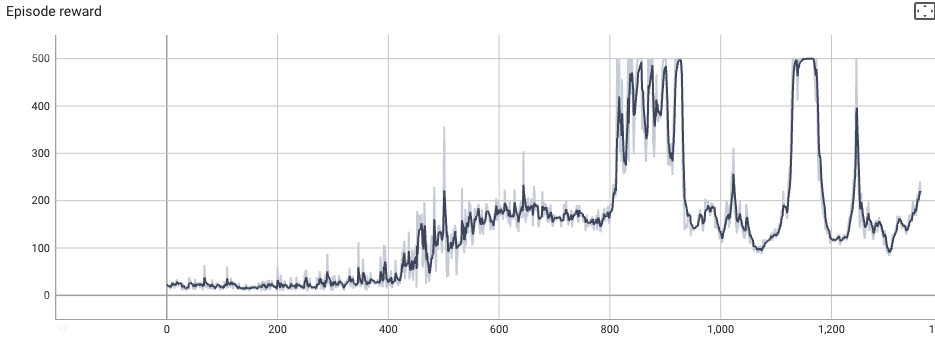

#### Maximum reward:
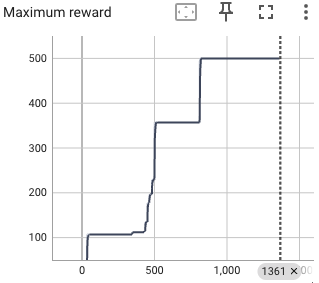